In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import math

## Function Definitions

In [2]:
def readExcelSheet1(excelfile):
    from pandas import read_excel
    return (read_excel(excelfile)).values

In [3]:
def readExcelRange(excelfile,sheetname="Sheet1",startrow=1,endrow=1,startcol=1,endcol=1):
    from pandas import read_excel
    values=(read_excel(excelfile, sheetname,header=None)).values;
    return values[startrow-1:endrow,startcol-1:endcol]

In [4]:
def readExcel(excelfile,**args):
    if args:
        data=readExcelRange(excelfile,**args)
    else:
        data=readExcelSheet1(excelfile)
    if data.shape==(1,1):
        return data[0,0]
    elif (data.shape)[0]==1:
        return data[0]
    else:
        return data

In [5]:
def writeExcelData(x,excelfile,sheetname,startrow,startcol):
    from pandas import DataFrame, ExcelWriter
    from openpyxl import load_workbook
    df=DataFrame(x)
    book = load_workbook(excelfile)
    writer = ExcelWriter(excelfile, engine='openpyxl') 
    writer.book = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    df.to_excel(writer, sheet_name=sheetname,startrow=startrow-1, startcol=startcol-1, header=False, index=False)
    writer.save()
    writer.close()

In [6]:
def getSheetNames(excelfile):
    from pandas import ExcelFile
    return (ExcelFile(excelfile)).sheet_names


In [7]:
def Build1DHistogramClassifier(X,T,B,xmin,xmax):
    HF=np.zeros(B).astype('int32');
    HM=np.zeros(B).astype('int32');
    binindices=(np.round(((B-1)*(X-xmin)/(xmax-xmin)))).astype('int32');
    for i,b in enumerate(binindices):
        if T[i]=='Female':
            HF[b]+=1;
        else:
            HM[b]+=1;
    return [HF, HM]

In [8]:
def Apply1DHistogramClassifier(queries,HF,HM,xmin,xmax):
    B=np.alen(HF);
    binindices=np.clip((np.round(((B-1)*(queries-xmin)/(xmax-xmin)))).astype('int32'),0,B-1);
    countF=HF[binindices];
    countM=HM[binindices];
    resultlabel=np.full(np.alen(binindices),"Indeterminate",dtype=object);
    resultprob=np.full(np.alen(binindices),np.nan,dtype=object);
    indicesF=countF>countM;
    indicesM=countM>countF;
    resultlabel[indicesF]="Female";
    resultlabel[indicesM]="Male";
    probF=countF/(countF+countM);
    probM=countM/(countF+countM);
    resultprob[indicesF]=probF[indicesF];
    resultprob[indicesM]=probM[indicesM];
    return resultlabel, resultprob

In [9]:
def BuildBayesianClassifer(x,mean,stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(stdev,2))))
    return (1/(math.sqrt(2*math.pi)*stdev))*exponent

## Prepare data

In [10]:
excelfile='/Users/eve7947/Downloads/Assignment_1_Data_and_Template.xlsx'

In [11]:
sheets=getSheetNames(excelfile);
sheets

['Data',
 'Classifiers - Full Data',
 'Classifiers - Partial Data',
 'Queries',
 'Observations',
 'ID']

In [12]:
data=readExcel(excelfile)
X=np.array(data[:50,0]*12+data[:50,1],dtype=float)
T=np.array([str(g) for g in data[:,2]])

In [13]:
queries=(readExcel(excelfile,
                  sheetname='Classifiers - Partial Data',
                  startrow=17,
                  endrow=17,
                  startcol=2,
                  endcol=7)).astype(float)
queries

array([55., 60., 65., 70., 75., 80.])

## Historgram Classifier

In [14]:
B=32;
xmin=52.0;
xmax=83.0;
[HF,HM]=Build1DHistogramClassifier(X,T,B,xmin,xmax);


In [15]:
print(HF)

[0 0 0 1 1 0 1 1 0 1 4 2 4 3 3 1 1 4 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
print(HM)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 2 3 3 2 1 4 1 2 0 0 0 1 0 0 0]


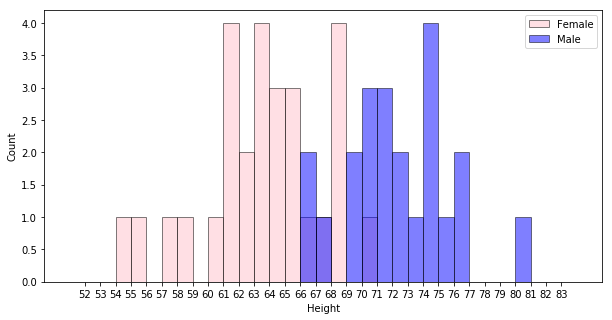

In [17]:
plt.figure(figsize=(10,5));
opacity = 0.5
[bincenters,binwidth]=np.linspace(xmin, xmax, num=B, retstep=True);
rects1 = plt.bar(bincenters-(binwidth/2), HF, binwidth,
                 alpha=opacity,
                 color='pink',
                 edgecolor='black',
                 label='Female')
rects2 = plt.bar(bincenters+(binwidth/2), HM, binwidth,
                 alpha=opacity,
                 color='b',
                 edgecolor='black',
                 label='Male')
plt.xlabel('Height')
plt.ylabel('Count')
plt.xticks(bincenters, bincenters.astype('int32'), fontsize=10)
plt.legend()
plt.show()

In [18]:
[resultHlabel, resultHprob]=Apply1DHistogramClassifier(queries,HF,HM,xmin,xmax)

/Users/eve7947/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Users/eve7947/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [19]:
print(DataFrame([resultHlabel, resultHprob]).T)
# The result produced upon executing the above statement is not shown in this document

               0    1
0         Female    1
1  Indeterminate  NaN
2         Female    1
3           Male    1
4           Male    1
5           Male    1


## Bayesian classifier

In [20]:
df = pd.DataFrame(data[:50,:], columns=['Height_Fight','Height_Inch','Gender'])

In [21]:
df.columns

Index(['Height_Fight', 'Height_Inch', 'Gender'], dtype='object')

In [22]:
female=df[df.Gender=='Female']
male=df[df.Gender=='Male']
female['Height']=female.Height_Fight*12+female.Height_Inch
male['Height']=male.Height_Fight*12+male.Height_Inch
fh = female['Height']
mh = male['Height']


/Users/eve7947/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/eve7947/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
fmean = np.mean(fh)
mmean = np.mean(mh)
print(np.mean(fh))
print(np.mean(mh))


64.07142857142857
71.81818181818181


In [24]:
fstd = np.std(fh)
mstd = np.std(mh)
print(np.std(fh))
print(np.std(mh))

3.881536619769578
3.379569144625656


In [25]:
NF = fh.count()
NM = mh.count()
print(fh.count())
print(mh.count())

28
22


In [30]:
FP = NF*BuildBayesianClassifer(80,fmean,fstd)
MP = NM*BuildBayesianClassifer(80,mmean,mstd)
F = FP/(FP + MP)
print (F)
M = MP/(FP + MP)
print(M)

0.004555443018553719
0.9954445569814462
